In [12]:
# Nate Ramos (he/him)
# CEE 266F: PSET 3

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.stats import bootstrap as bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats as ss
import scipy.signal
import math
import pymannkendall as mk
from IPython.display import Image

In [14]:
# Problem 1: Mann Kendall Hypothesis test for Monotonic Trend
# Note: you can use this code for ANY hypothesis test based on standard normal test statistic!
# Step 1: Calculate Z-score. Either do this by hand or write your own script to calculate it here

Year = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Fall = [0, 8, 11, 14, 16, 0, 8, 1, 2, 2, 1, 5, 1]
Winter = [0, 0, 5, 2, 17, 26, 8, 1, 6, 1, 2, 4, 1] 
Spring = [5, 3, 6, 3, 2, 9, 3, 1, 1, 3, 4, 2, 3] 
Summer = [8, 2, 5, 7, 19, 4, 9, 1, 4, 0, 1, 1, 0] 

# check monotonic trend for each
fall_results = mk.original_test(Fall)
print(fall_results)
winter_results = mk.original_test(Winter)
print('\n',winter_results)
spring_results = mk.original_test(Spring)
print('\n',spring_results)
summer_results = mk.original_test(Summer)
print('\n',summer_results)

z_fall = fall_results[3]
z_winter = winter_results[3]
z_spring = spring_results[3]
z_summer = summer_results[3]

# Step 2: Choose level of statistical significance
alpha = 0.05    # alpha = 0.10 implies 90% confidence interval

# Step 3a: Get inverse CDF value for chosen level of significance i.e. what Z-score gives this CDF value
# # For a two-tailed test, divide alpha by two and use abs value
CritVal = np.abs(ss.norm.ppf(alpha / 2))
# 1.95996

# Step 3b: Equivalently, find p-value of Z-score (multiple by 2 for two-sided test)
p_z_fall = ss.norm.sf(np.abs(z_fall)) * 2 # sf function is equivalent to 1 - CDF
p_z_winter = ss.norm.sf(np.abs(z_winter)) * 2
p_z_spring = ss.norm.sf(np.abs(z_spring)) * 2
p_z_summer = ss.norm.sf(np.abs(z_summer)) * 2

Mann_Kendall_Test(trend='no trend', h=False, p=0.49676899947365505, z=-0.679582269536737, Tau=-0.15384615384615385, s=-12.0, var_s=262.0, slope=-0.41666666666666663, intercept=4.5)

 Mann_Kendall_Test(trend='no trend', h=False, p=0.9018495205564321, z=0.12332528319564147, Tau=0.038461538461538464, s=3.0, var_s=263.0, slope=0.0, intercept=2.0)

 Mann_Kendall_Test(trend='no trend', h=False, p=0.2822966525833144, z=-1.075174404457249, Tau=-0.23076923076923078, s=-18.0, var_s=250.0, slope=-0.14583333333333331, intercept=3.875)

 Mann_Kendall_Test(trend='decreasing', h=True, p=0.019120136619703132, z=-2.343180380717188, Tau=-0.5, s=-39.0, var_s=263.0, slope=-0.5857142857142856, intercept=7.514285714285714)


In [15]:
# Step 4: Reject H0 if |Z-Score| > CritVal and, equivalently, if p-value < alpha/2
reject1_fall = CritVal < np.abs(z_fall)
reject2_fall = p_z_fall < alpha/2
print('Null hypothesis (H0): there is no trend in a given season at the 5% level.')
print('\nFall:|Z-Score| > CritVal is',reject1_fall,'and p-value', round(p_z_fall,3), '< alpha/2 is',reject2_fall,'; fail to reject H0 for the fall.') # cannot reject null hypothesis? 
# H0 - no trend at 5% level

reject1_winter = CritVal < np.abs(z_winter)
reject2_winter = p_z_winter < alpha/2
print('Winter:|Z-Score| > CritVal is',reject1_winter,'and p-value',round( p_z_winter,3), '< alpha/2 is',reject2_winter,'; fail to reject H0 for the winter.')
reject1_spring = CritVal < np.abs(z_spring)
reject2_spring = p_z_spring < alpha/2
print('Spring:|Z-Score| > CritVal is',reject1_spring,'and p-value',round(p_z_spring,3), '< alpha/2 is',reject2_spring,'; fail to reject H0 for the spring.')
reject1_summer = CritVal < np.abs(z_summer)
reject2_summer = p_z_summer < alpha/2
print('Summer:|Z-Score| > CritVal is',reject1_summer,'and p-value',round(p_z_summer,3), '< alpha/2 is',reject2_summer,'; reject H0 for the summer.')


Null hypothesis (H0): there is no trend in a given season at the 5% level.

Fall:|Z-Score| > CritVal is False and p-value 0.497 < alpha/2 is False ; fail to reject H0 for the fall.
Winter:|Z-Score| > CritVal is False and p-value 0.902 < alpha/2 is False ; fail to reject H0 for the winter.
Spring:|Z-Score| > CritVal is False and p-value 0.282 < alpha/2 is False ; fail to reject H0 for the spring.
Summer:|Z-Score| > CritVal is True and p-value 0.019 < alpha/2 is True ; reject H0 for the summer.


In [16]:
# load daily flow data on Turkey River at Garber, IL
allQ = pd.read_csv('TurkeyRiver_GarberIA.csv')

# convert first column to date, remove errors from 2nd
allQ['Date'] = pd.to_datetime(allQ['Date'],format="%Y-%m-%d")
allQ['Flow'] = pd.to_numeric(allQ['Flow'],errors='ignore')

# find year of each data point using .dt ; panda series
allQ['Year'] = allQ['Date'].dt.year
allQ['Month'] = allQ['Date'].dt.month

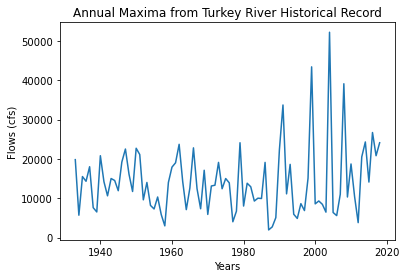

In [17]:
# Find annual maxima
maxQ = allQ.groupby('Year').max()

# what does the data look like
plt.plot(maxQ['Flow'])
plt.title('Annual Maxima from Turkey River Historical Record')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.show()

In [18]:
# %% Define useful functions
# Function to find moments of data
def findMoments(data):
    xbar = np.mean(data)
    std = np.std(data, ddof=1)
    skew = ss.skew(data, bias=False)

    return xbar, std, skew

# Function to fit data to a normal distribution, using either MLE or MOM
def fitNormal(data, method):
    assert method == 'MLE' or method == 'MOM', "method must = 'MLE' or 'MOM'"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        mu, sigma = ss.norm.fit(data)

    elif method == 'MOM':
        mu = xbar
        sigma = std

    return mu, sigma

# Function to make QQ plot for normal data with correlation test
def NormalPPCT(data, mu, sigma, title, figname):
    x_sorted = np.sort(data)
    p_observed = np.arange(1, len(data) + 1, 1) / (len(data) + 1)
    x_fitted = ss.norm.ppf(p_observed, mu, sigma)
    rho = np.corrcoef(x_sorted, x_fitted)[0, 1]

    plt.scatter(x_sorted, x_fitted, color='b')
    plt.plot(x_sorted, x_sorted, color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.savefig(figname)
    plt.clf()

    # Estimate p-value of corelation coefficient
    
    rhoVector = np.zeros(10000)
    for i in range(10000):
        x = ss.norm.rvs(mu, sigma, len(data))
        rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0, 1]

    count = 0
    for i in range(len(rhoVector)):
        if rho < rhoVector[i]:
            count = count + 1

    p_value = 1 - count / 10000
    return rho, p_value, figname

In [19]:
# Problem 2: 7Q10
allQ_years = allQ['Year'].unique()

# group flow data into a list per year
allQ_by_year = allQ.groupby('Year')['Flow'].apply(list)

Min7DayFlow = []
Yearly_Daily_Flows =[]
SevenDayFlow = []

# compute annual min 7-day flows
for year in allQ_years:
    Yearly_Daily_Flows = allQ_by_year[year]
    for s in range(len(Yearly_Daily_Flows)):
        if s > 5:
            SevenDayFlow_calc = sum(Yearly_Daily_Flows[s-6:s+1])
            SevenDayFlow.append(SevenDayFlow_calc) 
    Min7DayFlow.append(min(SevenDayFlow))
    SevenDayFlow = [] # reset list to ensure min of each year, not of multiple years

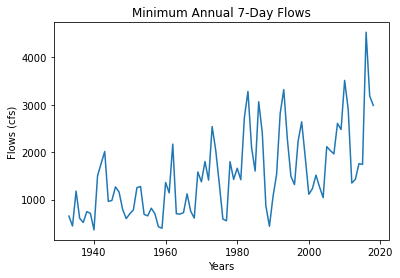

In [20]:
# Min 7Q10 Plot
plt.figure()
plt.plot(allQ_years, Min7DayFlow)
plt.title('Minimum Annual 7-Day Flows')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.show()

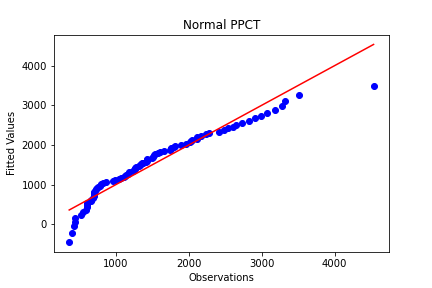

<Figure size 432x288 with 0 Axes>

In [21]:
# Problem 2a; Step 1 (normality)
# Test if Q710 data is normally distributed
plt.figure()
mu, sigma = fitNormal(Min7DayFlow,'MOM')
x_sorted = np.sort(Min7DayFlow)
rho_norm, p_value_norm, qq_1 = NormalPPCT(Min7DayFlow, mu, sigma, 'Normal PPCT', 'NormalPPCT.png')
Image(filename='NormalPPCT.png') 

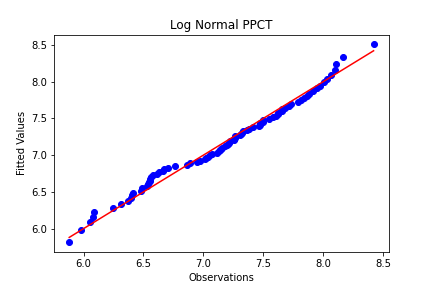

<Figure size 432x288 with 0 Axes>

In [22]:
# log transformation; tests significance of correlation coefficient; if low p -alue, reject H0 that data is from this distribution
mu, sigma = fitNormal(np.log(Min7DayFlow),'MOM')
rho_log, p_value_log, qq_2 = NormalPPCT(np.log(Min7DayFlow), mu, sigma, 'Log Normal PPCT', 'LogNormalPPCT.png')
Image(filename='LogNormalPPCT.png') 

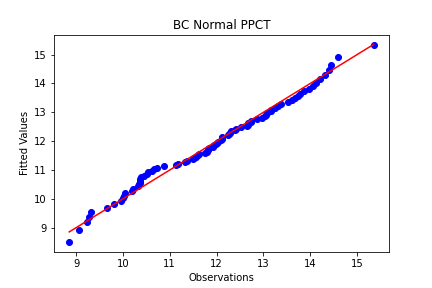

<Figure size 432x288 with 0 Axes>

In [23]:
# Box Cox transformation
BC_Min7DayFlow, llambda = ss.boxcox(Min7DayFlow)
mu_bc, sigma_bc = fitNormal(BC_Min7DayFlow,'MOM')
rho_bc, p_value_bc, qq_3 = NormalPPCT(BC_Min7DayFlow, mu_bc, sigma_bc, 'BC Normal PPCT', 'BCNormalPPCT.png')
Image(filename='BCNormalPPCT.png')

In [24]:
print('Normal Distribution parameter estimates:',round(rho_norm, 3), round(p_value_norm, 4))
print('Lognormal Transformation parameter estimates:',round(rho_log, 3), round(p_value_log, 4))
print('Box Cox Transformation parameter estimates:',round(rho_bc, 3), round(p_value_bc, 4))

print('\nBased on the statistically significant p-value for the normal distribution test (.0003<.05) and relatively low correlation coefficient (.963), I can reject the null hypothesis that the Min7DayFlow data comes from a normal distribution.')
print('\nAfter confidently rejecting the null hypothesis that the Min7DayFlow data comes from a normal distribution, I transformed the data in two ways (LN and BC) to see if one would be a better fit than the other.')
print('\nThe lognormal transformation rho and p-values increase significantly from the normal distribution values, and the Box Cox transformaiton values increase slightly more.')
print('\nCombined with a visual inspection of the Q-Q plots, the Box Cox transformation produces the best fit, as points from the Min7DayFlow data and the fitted Box Cox distribution mostly fall mostly along the reference line. The Lognormal distribution Q-Q plot also demonstrates a strong fit, but it has a slightly lower p-value and rho value than the Box Cox transformation.')
print('Ultimately, based on the Q-Q plots and the rho and p-values, I choose to transform the Min7DayFlow data via the Box Cox method, as it has the greatest correlation coefficient, the highest p-value for the null hypothesis, which results in a failure to reject the H_0 that the Min7DayFlow data comes from a Box Cox distribution type.')

Normal Distribution parameter estimates: 0.963 0.0004
Lognormal Transformation parameter estimates: 0.994 0.4827
Box Cox Transformation parameter estimates: 0.995 0.6266

Based on the statistically significant p-value for the normal distribution test (.0003<.05) and relatively low correlation coefficient (.963), I can reject the null hypothesis that the Min7DayFlow data comes from a normal distribution.

After confidently rejecting the null hypothesis that the Min7DayFlow data comes from a normal distribution, I transformed the data in two ways (LN and BC) to see if one would be a better fit than the other.

The lognormal transformation rho and p-values increase significantly from the normal distribution values, and the Box Cox transformaiton values increase slightly more.

Combined with a visual inspection of the Q-Q plots, the Box Cox transformation produces the best fit, as points from the Min7DayFlow data and the fitted Box Cox distribution mostly fall mostly along the reference li

<ipython-input-25-a0fd05d3006d>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(1/f, P)


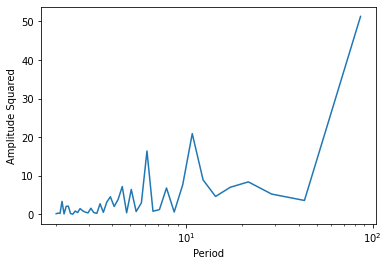

No seasonality/cyclicity via visual inspection of periodogram.


In [25]:
# %% Step 2: seasonality, look at periodogram of transformed annual maxima
f, P = scipy.signal.periodogram(BC_Min7DayFlow)
plt.semilogx(1/f, P)
plt.xlabel('Period')
plt.ylabel('Amplitude Squared')
plt.show()
print('No seasonality/cyclicity via visual inspection of periodogram.')

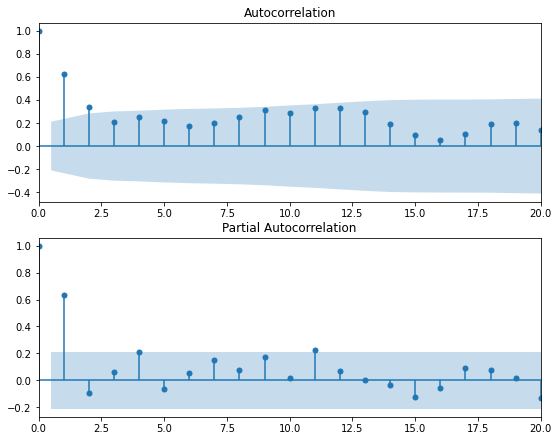

The ACF and PACF plots suggest that there is auto-correlation since the ACF has a sinusoidal/wave pattern and since the PACF seems to have a bit of a wave pattern. 
Upon visual inspection, I predict a ARMA(1,2) would best fit the transformed data.

For the AR portion, this is based on the ACF plot exhibiting a sinusoidal behavior, with the PACF plot appearing to cut off after 1 lag.

For the MA portion, the PACF plot seems to exhibit some type of sinusoidal behavior, while the ACF plot cuts off after 2 lags.


In [26]:
# Problem 2b: ACF and PACF of transformed 7Q10 data
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
sm.graphics.tsa.plot_acf(BC_Min7DayFlow,ax=ax)
ax.set_xlim([0,20])

ax = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_pacf(BC_Min7DayFlow,ax = ax)
ax.set_xlim([0,20])

fig.set_size_inches([9,7.25])
fig.savefig('TurkeyRiver_ACF_PACF.png')
plt.show()

print('The ACF and PACF plots suggest that there is auto-correlation since the ACF has a sinusoidal/wave pattern and since the PACF seems to have a bit of a wave pattern. \nUpon visual inspection, I predict a ARMA(1,2) would best fit the transformed data.')
print('\nFor the AR portion, this is based on the ACF plot exhibiting a sinusoidal behavior, with the PACF plot appearing to cut off after 1 lag.') 
print('\nFor the MA portion, the PACF plot seems to exhibit some type of sinusoidal behavior, while the ACF plot cuts off after 2 lags.')

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


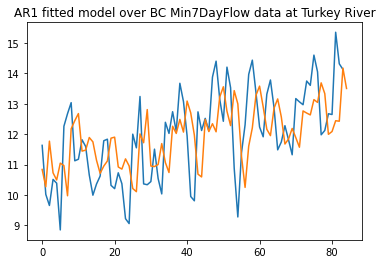

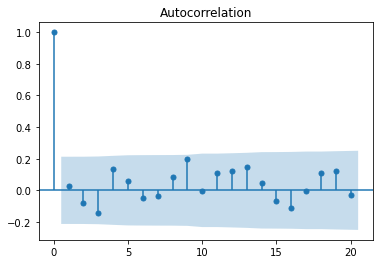

Model parameter estimates: [4.25778324 0.64589932] 
and their p-values: [2.11279121e-05 1.05749021e-14] 
Minimized AIC and BIC values: 0.338 , 0.425

I found below that the AR2 AIC value is greater than the AR1 AIC value, suggesting that a one-lag AR model is the best fit (as it minimizes AIC).


In [38]:
# %% Problem 2c fit pure AR1 model to BC Min7DayFlow; Example: https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html

# test p = 1
fit = AutoReg(BC_Min7DayFlow, lags = [1]).fit()
fit.params # regression coefficients, phi;for each lag term
fit.pvalues # for each lag, check if stat sig
fit.aic # lower AIC better (unitless); only use relative to other models
fit.bic 
AR1_Residuals = fit.resid

plt.plot(BC_Min7DayFlow[2::])
plt.plot(fit.fittedvalues)
plt.title('AR1 fitted model over BC Min7DayFlow data at Turkey River')
plt.show()

# %% look at acf of residuals, check if they are uncorrelated
sm.graphics.tsa.plot_acf(fit.resid)
plt.show()
# orange are the predicted ones, the fit using AR model

print('Model parameter estimates:',fit.params,'\nand their p-values:',fit.pvalues, '\nMinimized AIC and BIC values:',round(fit.aic,3),',',round(fit.bic,3))
print('\nI found below that the AR2 AIC value is greater than the AR1 AIC value, suggesting that a one-lag AR model is the best fit (as it minimizes AIC).')

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


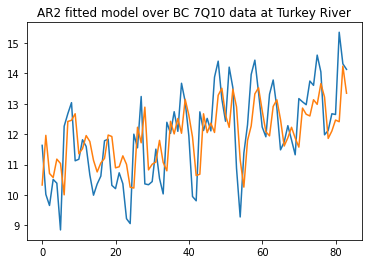

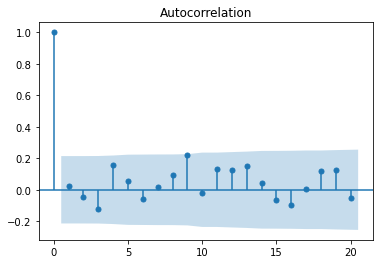

Model parameter estimates: [ 4.75689291  0.67593213 -0.07068792] 
and their p-values: [1.86034466e-05 3.67110336e-10 5.15640385e-01] 
Minimized AIC and BIC values: 0.348 , 0.464


In [28]:
# %% fit pure AR2 model to BC 7Q10
# test p = 2
fit = AutoReg(BC_Min7DayFlow, lags = [1,2]).fit()
fit.params 
fit.pvalues 
fit.aic 
fit.bic 

plt.plot(BC_Min7DayFlow[2::])
plt.plot(fit.fittedvalues)
plt.title('AR2 fitted model over BC 7Q10 data at Turkey River')
plt.show()

# %% look at acf of residualsl check if they are uncorrelated
sm.graphics.tsa.plot_acf(fit.resid)
plt.show()
print('Model parameter estimates:',fit.params,'\nand their p-values:',fit.pvalues, '\nMinimized AIC and BIC values:',round(fit.aic,3),',',round(fit.bic,3))

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


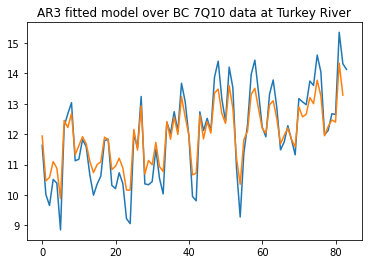

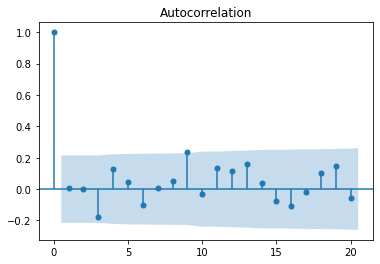

Model parameter estimates: [ 4.12724526  0.70123891 -0.11913864  0.07506594] 
and their p-values: [1.03000314e-03 1.19555351e-10 3.59602370e-01 4.97632791e-01] 
Minimized AIC and BIC values: 0.363 , 0.509


In [29]:
# %% fit pure AR3 model to BC Min7DayFlow
# test p = 3
fit = AutoReg(BC_Min7DayFlow, lags = [1,2,3]).fit()
fit.params
fit.pvalues
fit.aic 
fit.bic 

plt.plot(BC_Min7DayFlow[2::])
plt.plot(fit.fittedvalues)
plt.title('AR3 fitted model over BC 7Q10 data at Turkey River')
plt.show()

# %% look at acf of residualsl check if they are uncorrelated
sm.graphics.tsa.plot_acf(fit.resid)
plt.show()

print('Model parameter estimates:',fit.params,'\nand their p-values:',fit.pvalues, '\nMinimized AIC and BIC values:',round(fit.aic,3),',', round(fit.bic,3))

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


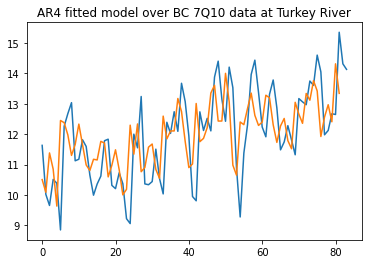

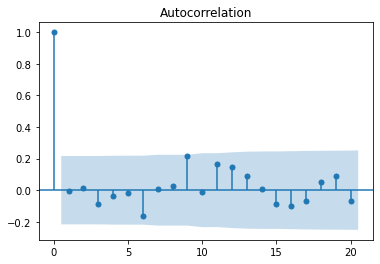

Model parameter estimates: [ 3.41900677  0.70722889 -0.13346206 -0.07630885  0.2220862 ] 
and their p-values: [8.89190062e-03 2.58305896e-11 2.98867608e-01 5.55813158e-01
 3.93648587e-02] 
Minimized AIC and BIC values: 0.313 , 0.489
While the AIC for AR4 is lower than for AR1, AR4 has greater p-values than AR1 that are not statistically significant (>.05), suggesting AR1 is a better fit (as the high p-values correspond to an unacceptable level of probability that these estimates were produced by chance/error).


In [30]:
# %% fit pure AR4 model to BC Min7DayFlow
# test p = 4
fit = AutoReg(BC_Min7DayFlow, lags = [1,2,3,4]).fit()
fit.params
fit.pvalues 
fit.aic 
fit.bic  

plt.plot(BC_Min7DayFlow[2::])
plt.plot(fit.fittedvalues)
plt.title('AR4 fitted model over BC 7Q10 data at Turkey River')
plt.show()

# %% look at acf of residualsl check if they are uncorrelated
sm.graphics.tsa.plot_acf(fit.resid)
plt.show()

print('Model parameter estimates:',fit.params,'\nand their p-values:',fit.pvalues, '\nMinimized AIC and BIC values:',round(fit.aic,3),',', round(fit.bic,3))
print('While the AIC for AR4 is lower than for AR1, AR4 has greater p-values than AR1 that are not statistically significant (>.05), suggesting AR1 is a better fit (as the high p-values correspond to an unacceptable level of probability that these estimates were produced by chance/error).')

In [39]:
allQ_years_test = allQ_years[:-1]
BC_Min7DayFlow_Residuals = pd.DataFrame({"AR1_Residuals" :AR1_Residuals,'allQ_years_test':allQ_years_test})
years = np.arange(1,len(BC_Min7DayFlow_Residuals)+ 1)

                            OLS Regression Results                            
Dep. Variable:          AR1_Residuals   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7.725
Date:                Tue, 08 Feb 2022   Prob (F-statistic):            0.00674
Time:                        23:48:14   Log-Likelihood:                -128.21
No. Observations:                  85   AIC:                             260.4
Df Residuals:                      83   BIC:                             265.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -26.8530      9.663     

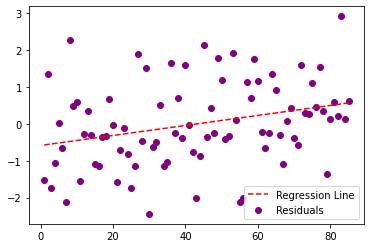

In [40]:
# Problem 2d, OLS regression
mod = smf.ols(formula='AR1_Residuals ~ allQ_years_test', data=BC_Min7DayFlow_Residuals)
results = mod.fit()
print(results.summary())

fig, ax = plt.subplots()
ax.scatter(years,BC_Min7DayFlow_Residuals['AR1_Residuals'], color = 'purple', label = 'Residuals')
ax.plot(years,results.fittedvalues,'r--', label = 'Regression Line')
plt.legend()

In [41]:
print(results.pvalues)
print('The p-value for the intercept and trend parameter is statistically significant (<.05).')

Intercept          0.006741
allQ_years_test    0.006737
dtype: float64
The p-value for the intercept and trend parameter is statistically significant (<.05).


In [51]:
# Problem 2d, 2-sided MK test
AR1_Results = mk.original_test(AR1_Residuals)
print(AR1_Results)

z_AR1 = AR1_Results[3]

# Step 2: Choose level of statistical significance
alpha = 0.05    
# Step 3a: Get inverse CDF value for chosen level of significance i.e. what Z-score gives this CDF value
# # For a two-tailed test, divide alpha by two and use abs value
CritVal = np.abs(ss.norm.ppf(alpha / 2))

# Step 3b: Equivalently, find p-value of Z-score (multiple by 2 for two-sided test)
p_z_AR1 = ss.norm.sf(np.abs(z_AR1)) * 2 # sf function is equivalent to 1 - CDF
print('\nBased on the Mann-Kendall test p-value of',round(p_z_AR1,3),'< .05, we reject the null hypothesis that there is no increasing trend at the 5% level for the residuals of our AR1 model on the Box Cox Min7DayFlow data for Turkey River.')
print('This p-value is slightly smaller than that of the estimates from the regression of the residuals. Next, I will conduct a one-sided test to evaluate a H0 that there is no increasing trend in the residuals.')

Mann_Kendall_Test(trend='increasing', h=True, p=0.0055285797820538995, z=2.7745049199848983, Tau=0.20504201680672268, s=732.0, var_s=69416.66666666667, slope=0.014702710464501553, intercept=-0.7389541571670343)

Based on the Mann-Kendall test p-value of 0.006 < .05, we reject the null hypothesis that there is no increasing trend at the 5% level for the residuals of our AR1 model on the Box Cox Min7DayFlow data for Turkey River.
This p-value is slightly smaller than that of the estimates from the regression of the residuals. Next, I will conduct a one-sided test to evaluate a H0 that there is no increasing trend in the residuals.


In [54]:
# Problem 2d, 1-sided MK test
AR1_Results_1side = mk.original_test(AR1_Residuals)

z_AR1_1side = AR1_Results_1side[3]

# Step 2: Choose level of statistical significance
alpha = 0.05    

# Step 3a: Get inverse CDF value for chosen level of significance i.e. what Z-score gives this CDF value
CritVal = ss.norm.ppf(alpha)

# Step 3b: Equivalently, find p-value of Z-score 
p_z_AR1_1side = ss.norm.sf(np.abs(z_AR1_1side))  
print('Based on the Mann-Kendall test p-value of',round(p_z_AR1_1side,3),'< .05, we reject the null hypothesis that there is no trend in the residuals of our AR1 model .')
print('This p-value is slightly smaller than that of the estimates from the regression of the residuals and our 2-sided MK test. This provides further evidence that there is an increasing trend in our residuals, as seen in the regression test p-value outputs.')

Based on the Mann-Kendall test p-value of 0.003 < .05, we reject the null hypothesis that there is no trend in the residuals of our AR1 model .
This p-value is slightly smaller than that of the estimates from the regression of the residuals and our 2-sided MK test. This provides further evidence that there is an increasing trend in our residuals, as seen in the regression test p-value outputs.


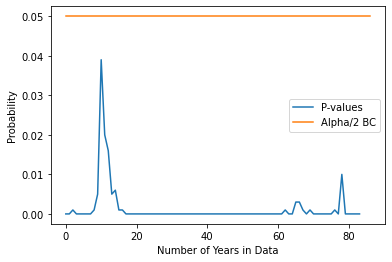

Virtually all years have a p-value below the .05 threshold (at around 15, probability approaches .05, suggesting there may not be a change point there).
This suggests that there is a change point nearly every year of the time series.
However, our results from 2d suggest there may be an increasing trend in the dataset, as we rejected null hypotheses that there was no increasing trend in the residuals, and that the linear regression model estimates were not 0.
Therefore, there may be another trend in the dataset influencing this pattern in the residuals, and determining change points may not be the best method for determining this for a multi-year timeseries.


In [55]:
# Problem, 2e: test for change point with bootstrapping - Lecture 20 slide 10;  using transformed data
# H_0 for bootstrapping; if p > .05, or below .95, don't have significant change point; p-values < threshold, have a change point
nSamples = 1000
BC_Min7DayFlow_df = pd.DataFrame({"Years": allQ_years,"BC_Min7DayFlow": BC_Min7DayFlow})
p_values = np.ones(len(BC_Min7DayFlow_df['BC_Min7DayFlow']) - 1)

# If we're not sure where the change point might be, loop over the time series and test every possible time period
for i in range(len(BC_Min7DayFlow_df['BC_Min7DayFlow']) - 1):

    # For each potential time of change point,
    # bootstrap nSamples from the time before and after the potential change point
    x = bootstrap(np.array(BC_Min7DayFlow_df['BC_Min7DayFlow'].iloc[:(i + 1)]), nSamples) # Before the change point
    y = bootstrap(np.array(BC_Min7DayFlow_df['BC_Min7DayFlow'].iloc[(i + 1):]), nSamples) # After the change point

    # Compute S, or the number of samples for which the median of X is greater than the median of Y
    S = 0
    for j in range(nSamples):
        if np.median(x[j, :]) > np.median(y[j, :]):    # This uses median; could use any other statistic
            S += 1

    # Average S over nSamples
    p_values[i] = S / nSamples

# Plot p-values of each potential change point
plt.plot(p_values[0:-1], label = 'P-values')
# Plot alpha/2 as threshold for statistical significance (use 1-alpha/2 if necessary)
plt.plot([0, len(BC_Min7DayFlow_df['BC_Min7DayFlow'])], [0.05, 0.05],label = 'Alpha/2 BC')
plt.xlabel('Number of Years in Data')
plt.ylabel('Probability')
plt.legend()
plt.show()

print('Virtually all years have a p-value below the .05 threshold (at around 15, probability approaches .05, suggesting there may not be a change point there).')
print('This suggests that there is a change point nearly every year of the time series.')
print('However, our results from 2d suggest there may be an increasing trend in the dataset, as we rejected null hypotheses that there was no increasing trend in the residuals, and that the linear regression model estimates were not 0.')
print('Therefore, there may be another trend in the dataset influencing this pattern in the residuals, and determining change points may not be the best method for determining this for a multi-year timeseries.')